In [11]:
!pip install faker
!pip install fastapi nest-asyncio pyngrok uvicorn


In [2]:

# predictive_banking_project.py
# Single-file end-to-end reproducible implementation as requested.

# ---------------------------
# 0) Imports and global setup
# ---------------------------
import os                                  # file/directory operations
import random                              # random utilities
import zipfile                             # for packaging outputs
from datetime import datetime, timedelta  # date operations
import numpy as np                         # numerical computing
import pandas as pd                        # dataframes
from faker import Faker                     # synthetic realistic data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib                                # save/load models
import warnings
warnings.filterwarnings("ignore")             # keep output tidy

RND = 42                                      # reproducible seed
random.seed(RND)
np.random.seed(RND)
fake = Faker()
Faker.seed(RND)

# Create output directories
OUTPUT_DIR = "project_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "figures"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "data"), exist_ok=True)

In [3]:
# ---------------------------
# 1) Synthetic datasets
# ---------------------------

# 1A) Loan dataset generation
def generate_loan_dataset(n_customers=10000):
    """
    Generates a synthetic loan dataset with derived features and a probabilistic target.
    """
    rows = []
    for i in range(n_customers):
        customer_id = f"C{100000 + i}"
        age = int(np.clip(np.random.normal(40, 10), 18, 75))                 # realistic ages
        income = int(max(8000, np.random.normal(60000, 30000)))             # annual income
        credit_score = int(np.clip(np.random.normal(650, 70), 300, 850))     # credit bureau-like score
        loan_amount = int(np.clip(np.random.exponential(15000) + 5000, 1000, income*3))
        interest_rate = round(np.clip(np.random.normal(0.12, 0.03), 0.03, 0.25), 4)
        loan_term = int(np.random.choice([12, 24, 36, 48, 60]))              # months
        # derived features:
        income_to_loan = income / (loan_amount + 1)
        # monthly EMI using amortization formula
        monthly_rate = interest_rate / 12
        emi = (loan_amount * monthly_rate) / (1 - (1 + monthly_rate) ** (-loan_term))
        tenure_years = int(np.clip(np.random.exponential(3), 0, 40))
        # repayment_status probabilistic: high risk if low credit score, low income_to_loan, high emi relative to income
        risk_score = (700 - credit_score) * 0.5 + (1 / (income_to_loan + 1)) * 50 + (emi / (income / 12)) * 100
        prob_default = 1 / (1 + np.exp(-0.02 * (risk_score - 20)))  # logistic transform => [0,1]
        repayment_status = int(np.random.rand() < prob_default)    # 1=default, 0=no default
        rows.append({
            "customer_id": customer_id,
            "age": age,
            "income": income,
            "credit_score": credit_score,
            "loan_amount": loan_amount,
            "interest_rate": interest_rate,
            "loan_term": loan_term,
            "emi": round(emi, 2),
            "income_to_loan": round(income_to_loan, 4),
            "tenure_years": tenure_years,
            "repayment_status": repayment_status
        })
    return pd.DataFrame(rows)

loan_df = generate_loan_dataset(n_customers=8000)
loan_df.to_csv(os.path.join(OUTPUT_DIR, "data", "loan_data.csv"), index=False)

# 1B) Transactions dataset generation (for segmentation)
def generate_transactions(customers, avg_txn_per_customer=80, months=24):
    """
    Generates a transactional history for each customer over the past `months`.
    """
    rows = []
    start_date = datetime.now() - timedelta(days=30*months)
    txn_types = ["deposit", "withdrawal", "payment", "transfer", "purchase"]
    for cust in customers:
        n_txn = max(5, int(np.random.poisson(avg_txn_per_customer)))
        for t in range(n_txn):
            txn_id = f"T{random.randint(10000000,99999999)}"
            txn_type = random.choices(txn_types, weights=[0.2,0.2,0.25,0.15,0.2])[0]
            # amount depends on type and customer income distribution (fetch income)
            income = int(loan_df.loc[loan_df['customer_id'] == cust, 'income'].values[0])
            if txn_type == "deposit":
                amount = max(50, np.random.normal(income/12, income/24))
            elif txn_type == "withdrawal":
                amount = max(10, np.random.exponential(income/120))
            elif txn_type == "payment":
                amount = max(10, np.random.exponential(200))
            elif txn_type == "transfer":
                amount = max(5, np.random.exponential(income/300))
            else:  # purchase
                amount = max(5, np.random.exponential(80))
            txn_date = start_date + timedelta(days=random.randint(0, months*30))
            rows.append({
                "customer_id": cust,
                "transaction_id": txn_id,
                "transaction_amount": round(float(amount), 2),
                "transaction_type": txn_type,
                "transaction_date": txn_date.strftime("%Y-%m-%d")
            })
    return pd.DataFrame(rows)

txn_df = generate_transactions(loan_df['customer_id'].tolist(), avg_txn_per_customer=60, months=24)
txn_df.to_csv(os.path.join(OUTPUT_DIR, "data", "transactions.csv"), index=False)

# 1C) Interaction dataset for recommendation engine
def generate_interactions(customers, n_products=200, avg_interactions_per_customer=40):
    """
    Generates customer-product interactions with types (viewed, clicked, purchased).
    """
    products = [f"P{1000 + i}" for i in range(n_products)]
    rows = []
    for cust in customers:
        n_inter = max(5, int(np.random.poisson(avg_interactions_per_customer)))
        for _ in range(n_inter):
            product_id = random.choice(products)
            interaction_type = random.choices(["viewed", "clicked", "purchased"], weights=[0.7, 0.2, 0.1])[0]
            # weight for collaborative filtering (purchased=3, clicked=1.5, viewed=1)
            weight = {"viewed": 1.0, "clicked": 1.5, "purchased": 3.0}[interaction_type]
            # pick interaction date in last 2 years
            interaction_date = datetime.now() - timedelta(days=random.randint(0, 730))
            rows.append({
                "customer_id": cust,
                "product_id": product_id,
                "interaction_type": interaction_type,
                "weight": weight,
                "interaction_date": interaction_date.strftime("%Y-%m-%d")
            })
    return pd.DataFrame(rows), products

interactions_df, product_list = generate_interactions(loan_df['customer_id'].tolist(), n_products=300, avg_interactions_per_customer=30)
interactions_df.to_csv(os.path.join(OUTPUT_DIR, "data", "interactions.csv"), index=False)

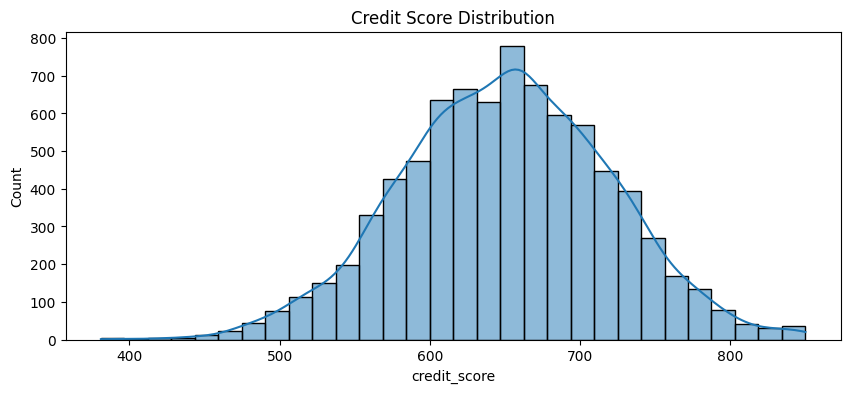

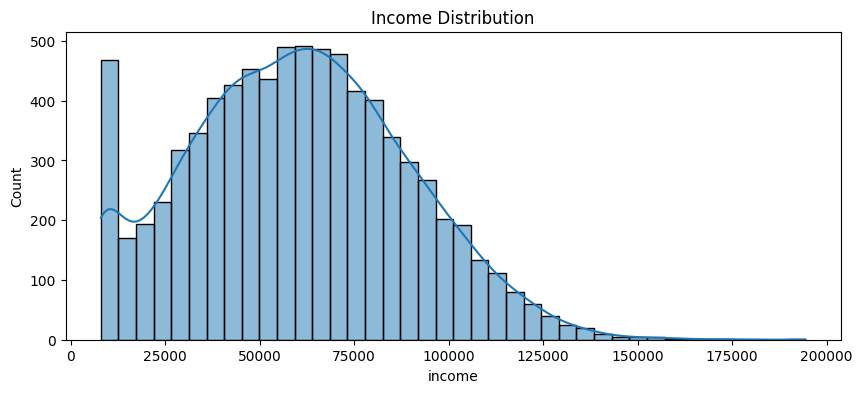

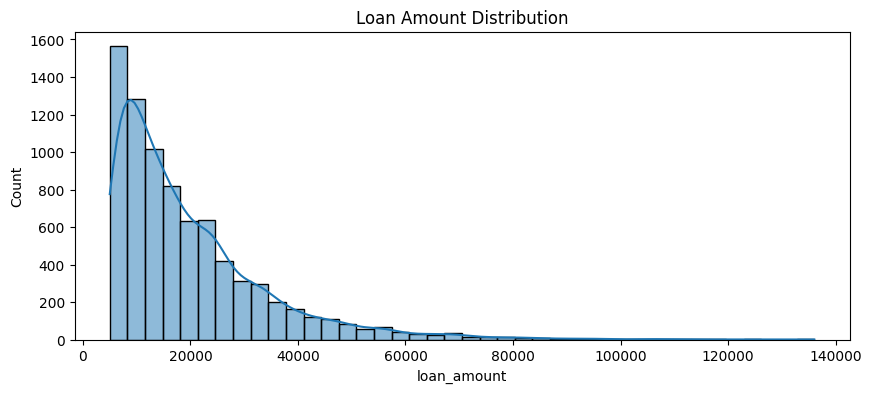

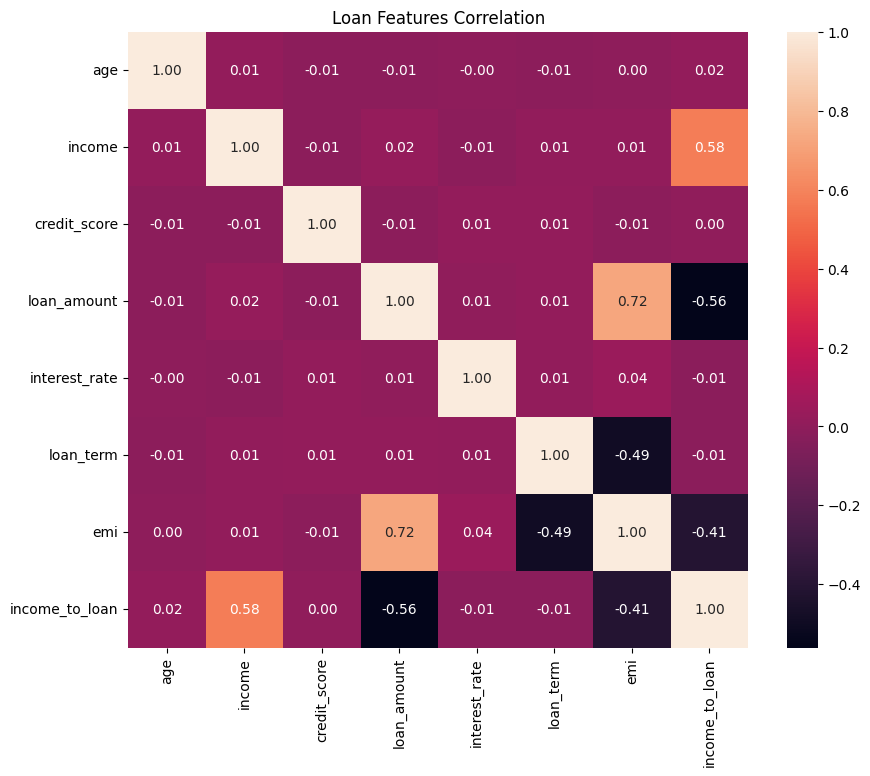

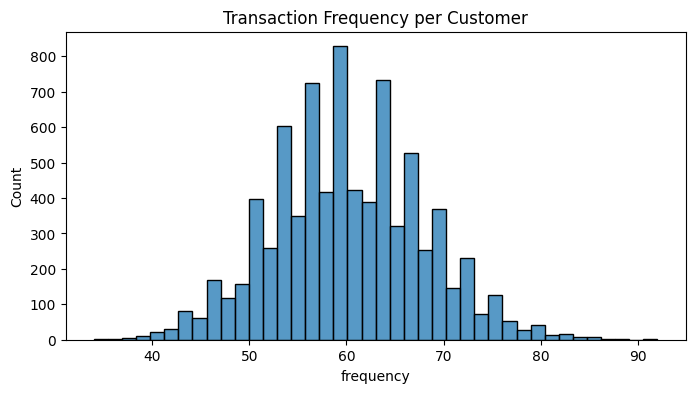

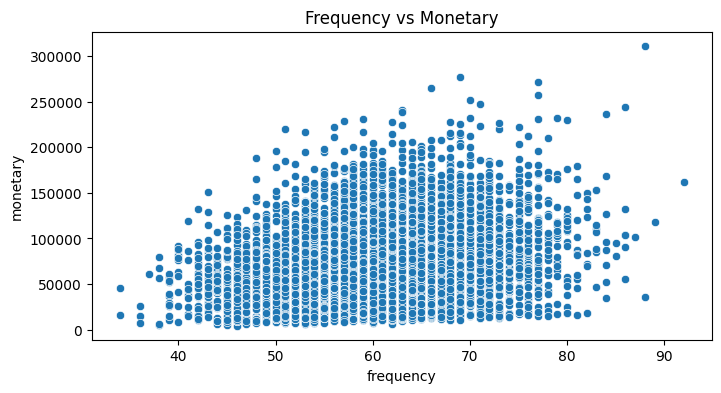

In [4]:
# ---------------------------
# 2) Feature engineering & EDA
# ---------------------------

# 2A) Loan EDA & derived augmentations (already has some derived fields)
loan_df.describe(include='all').to_csv(os.path.join(OUTPUT_DIR, "figures", "loan_summary_stats.csv"))
# plot distributions: credit_score, income, loan_amount
plt.figure(figsize=(10,4))
sns.histplot(loan_df['credit_score'], bins=30, kde=True)
plt.title("Credit Score Distribution")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "credit_score_dist.png"))
plt.show()
plt.close()

plt.figure(figsize=(10,4))
sns.histplot(loan_df['income'], bins=40, kde=True)
plt.title("Income Distribution")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "income_dist.png"))
plt.show()
plt.close()

plt.figure(figsize=(10,4))
sns.histplot(loan_df['loan_amount'], bins=40, kde=True)
plt.title("Loan Amount Distribution")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "loan_amount_dist.png"))
plt.show()
plt.close()

# correlation matrix for loan dataset
plt.figure(figsize=(10,8))
sns.heatmap(loan_df[['age','income','credit_score','loan_amount','interest_rate','loan_term','emi','income_to_loan']].corr(), annot=True, fmt=".2f")
plt.title("Loan Features Correlation")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "loan_corr.png"))
plt.show()
plt.close()


# 2B) Transaction-level feature engineering (RFM-like)
txn_df['transaction_date'] = pd.to_datetime(txn_df['transaction_date'])
# calculate recency (days since last txn), frequency, monetary (sum) per customer
snapshot_date = datetime.now()
agg_txn = txn_df.groupby('customer_id').agg(
    recency_days = ('transaction_date', lambda x: (snapshot_date - x.max()).days),
    frequency = ('transaction_id', 'count'),
    monetary = ('transaction_amount', 'sum'),
    avg_txn_amount = ('transaction_amount', 'mean')
).reset_index()
agg_txn.to_csv(os.path.join(OUTPUT_DIR, "data", "customer_txn_agg.csv"), index=False)

# Merge loan_df with txn aggregates for downstream tasks
customer_profile = loan_df.merge(agg_txn, on='customer_id', how='left').fillna({
    'recency_days': 999, 'frequency':0, 'monetary':0, 'avg_txn_amount':0
})

# Save a profile snapshot
customer_profile.to_csv(os.path.join(OUTPUT_DIR, "data", "customer_profile.csv"), index=False)

# Quick EDA plots for segmentation variables
plt.figure(figsize=(8,4))
sns.histplot(customer_profile['frequency'], bins=40, kde=False)
plt.title("Transaction Frequency per Customer")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "frequency_dist.png"))
plt.show()
plt.close()

plt.figure(figsize=(8,4))
sns.scatterplot(data=customer_profile, x='frequency', y='monetary')
plt.title("Frequency vs Monetary")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "freq_vs_monetary.png"))
plt.show()
plt.close()

# 2C) Interaction-level summary for recommender
# aggregate weight per (customer,product)
inter_agg = interactions_df.groupby(['customer_id','product_id'])['weight'].sum().reset_index()
inter_agg.to_csv(os.path.join(OUTPUT_DIR, "data", "interactions_agg.csv"), index=False)



In [5]:
# ---------------------------
# 3) Supervised Learning: Loan Default Prediction
# ---------------------------

# 3A) Prepare features and target
'''loan_features = ['age','income','credit_score','loan_amount','interest_rate','loan_term','emi','income_to_loan','tenure_years','frequency','monetary','avg_txn_amount']
# ensure merged columns exist in loan_df by merging customer_profile info
loan_model_df = loan_df.merge(agg_txn, on='customer_id', how='left').fillna({'recency_days':999,'frequency':0,'monetary':0,'avg_txn_amount':0})'''
loan_features = [
    "age",
    "income",
    "credit_score",
    "loan_amount",
    "interest_rate",
    "loan_term",
    "emi",
    "income_to_loan",
    "tenure_years"
]

loan_model_df = loan_df.merge(agg_txn, on='customer_id', how='left')

X = loan_model_df[loan_features]
y = loan_model_df['repayment_status']

# 3B) Preprocessing + Model pipeline
numeric_features = loan_features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=RND, n_jobs=-1))
])

# 3C) Train-test split and hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RND)

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_split': [2, 5]
}
grid = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# Save best model
joblib.dump(best_model, os.path.join(OUTPUT_DIR, "models", "best_loan_model.pkl"))

# 3D) Evaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba)
}
pd.Series(metrics).to_csv(os.path.join(OUTPUT_DIR, "figures", "loan_model_metrics.csv"))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Loan Default Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "loan_confusion_matrix.png"))
plt.close()

# Feature importances
# Extract numeric pipeline and get importances aligned with numeric features
rf = best_model.named_steps['clf']
importances = rf.feature_importances_
fi = pd.Series(importances, index=numeric_features).sort_values(ascending=False)
fi.to_csv(os.path.join(OUTPUT_DIR, "figures", "feature_importances.csv"))
plt.figure(figsize=(8,4))
fi.head(10).plot.bar()
plt.title("Top 10 Feature Importances")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "feature_importance_top10.png"))
plt.close()


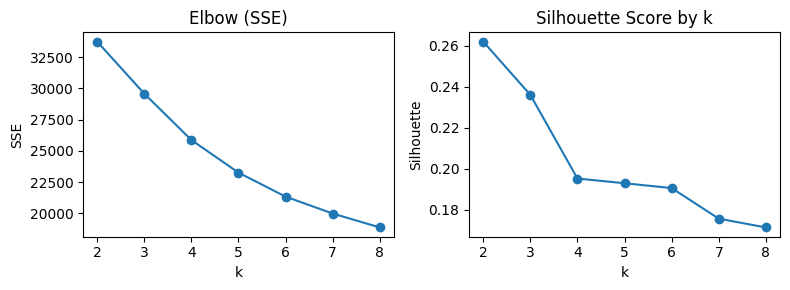

['project_outputs/models/kmeans_customers.pkl']

In [6]:
# ---------------------------
# 4) Unsupervised Learning: Customer Segmentation
# ---------------------------

# 4A) Prepare features for clustering (RFM + credit score + income)
cluster_features = ['recency_days','frequency','monetary','avg_txn_amount','credit_score','income']
cluster_df = customer_profile[cluster_features].copy()
# handle missing
cluster_df['monetary'] = cluster_df['monetary'].fillna(0)
# scale
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)

# 4B) Choose K via elbow and silhouette
sse = []
sil_scores = []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RND, n_init=10)
    labels = km.fit_predict(cluster_scaled)
    sse.append(km.inertia_)
    sil_scores.append(silhouette_score(cluster_scaled, labels))

# save elbow & silhouette plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow (SSE)')
plt.xlabel('k')
plt.ylabel('SSE')
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score by k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "k_selection.png"))
plt.show()
plt.close()

# choose k with highest silhouette
best_k = K_range[int(np.argmax(sil_scores))]
km_final = KMeans(n_clusters=best_k, random_state=RND, n_init=20)
cluster_labels = km_final.fit_predict(cluster_scaled)
customer_profile['cluster'] = cluster_labels

# cluster profiling
cluster_summary = customer_profile.groupby('cluster').agg({
    'customer_id':'count',
    'recency_days':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'credit_score':'mean',
    'income':'mean'
}).rename(columns={'customer_id':'size'}).reset_index()
cluster_summary.to_csv(os.path.join(OUTPUT_DIR, "figures", "cluster_summary.csv"), index=False)

# PCA plot for visualization
pca = PCA(n_components=2, random_state=RND)
proj = pca.fit_transform(cluster_scaled)
plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=cluster_labels, cmap='tab10', s=10)
plt.title("Customer Segments (PCA 2D)")
plt.savefig(os.path.join(OUTPUT_DIR, "figures", "clusters_pca.png"))
plt.close()

joblib.dump(km_final, os.path.join(OUTPUT_DIR, "models", "kmeans_customers.pkl"))



In [7]:
# ---------------------------
# 5) Recommendation Engine
# ---------------------------

# 5A) Build user-item matrix
# Use inter_agg dataframe with weight sums
user_item = inter_agg.pivot(index='customer_id', columns='product_id', values='weight').fillna(0)

# 5B) Item-based collaborative filtering using cosine similarity (simple)
from sklearn.metrics.pairwise import cosine_similarity
item_matrix = user_item.T  # items x users
# to reduce dimensionality / noise, use TruncatedSVD on item-user matrix
svd_k = 50
svd = TruncatedSVD(n_components=min(svd_k, min(item_matrix.shape)-1), random_state=RND)
item_factors = svd.fit_transform(item_matrix)  # item latent vectors
# compute item-item similarity in latent space
item_similarity = cosine_similarity(item_factors)

# map product index to similarity matrix
product_index = list(item_matrix.index)
item_sim_df = pd.DataFrame(item_similarity, index=product_index, columns=product_index)

# 5C) Recommendation function: given customer, score items by similarity to items they've interacted with
def recommend_items_for_customer(customer_id, top_k=10, user_item_matrix=user_item, sim_df=item_sim_df):
    """
    Returns top_k recommended products for a given customer_id (not including already interacted items).
    """
    if customer_id not in user_item_matrix.index:
        return []  # cold start: no interactions
    user_vector = user_item_matrix.loc[customer_id]
    interacted = user_vector[user_vector > 0].index.tolist()
    # score candidate items: sum(similarity * user_interaction_weight) across items user interacted with
    scores = {}
    for candidate in sim_df.columns:
        if candidate in interacted:
            continue
        # dot product: similarity to each item * user's weight for that item
        sim_to_user_items = sim_df.loc[candidate, interacted].values if len(interacted)>0 else np.array([])
        user_weights = user_vector[interacted].values if len(interacted)>0 else np.array([])
        score = float(np.dot(sim_to_user_items, user_weights)) if len(sim_to_user_items)>0 else 0.0
        scores[candidate] = score
    # return top_k sorted by score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [p for p, s in ranked]

# 5D) Offline evaluation: Precision@K, Recall@K
def precision_recall_at_k(test_interactions, train_interactions, user_item_matrix_train, sim_df, k=10):
    """
    test_interactions: DataFrame of (customer_id, product_id) that occurred in test set
    train_interactions: DataFrame of (customer_id, product_id) in train set
    """
    # build mapping: for each user, true set of test items and train items
    true_map = test_interactions.groupby('customer_id')['product_id'].apply(set).to_dict()
    train_map = train_interactions.groupby('customer_id')['product_id'].apply(set).to_dict()
    precisions = []
    recalls = []
    users = list(true_map.keys())
    for u in users:
        recommended = recommend_items_for_customer(u, top_k=k, user_item_matrix=user_item_matrix_train, sim_df=sim_df)
        true_items = true_map.get(u, set())
        if len(true_items) == 0:
            continue
        recommended_set = set(recommended)
        n_relevant = len(recommended_set & true_items)
        precisions.append(n_relevant / k)
        recalls.append(n_relevant / len(true_items))
    return np.mean(precisions) if precisions else 0.0, np.mean(recalls) if recalls else 0.0

# Create a train/test split on interactions at customer level (time-based split would be better; here a pseudo split)
# Split interactions_df by date: last 30% of interactions per user as "test"
interactions_df['interaction_date'] = pd.to_datetime(interactions_df['interaction_date'])
interactions_df = interactions_df.sort_values('interaction_date')
train_rows = []
test_rows = []
for cust, grp in interactions_df.groupby('customer_id'):
    n = len(grp)
    split = max(1, int(0.7 * n))
    train_rows.append(grp.iloc[:split])
    test_rows.append(grp.iloc[split:])
train_df = pd.concat(train_rows)
test_df = pd.concat(test_rows) if len(test_rows) else pd.DataFrame(columns=interactions_df.columns)

# build train user_item matrix
train_agg = train_df.groupby(['customer_id','product_id'])['weight'].sum().reset_index()
train_ui = train_agg.pivot(index='customer_id', columns='product_id', values='weight').fillna(0)

# rebuild SVD factors on train set items
item_matrix_train = train_ui.T
svd_train = TruncatedSVD(n_components=min(50, min(item_matrix_train.shape)-1), random_state=RND)
item_factors_train = svd_train.fit_transform(item_matrix_train)
item_sim_train = cosine_similarity(item_factors_train)
product_index_train = list(item_matrix_train.index)
sim_df_train = pd.DataFrame(item_sim_train, index=product_index_train, columns=product_index_train)

# Evaluate Precision@10 and Recall@10
prec10, rec10 = precision_recall_at_k(test_df[['customer_id','product_id']], train_df[['customer_id','product_id']], train_ui, sim_df_train, k=10)
pd.Series({"prec@10":prec10, "recall@10":rec10}).to_csv(os.path.join(OUTPUT_DIR, "figures", "recommender_metrics.csv"))

# Save recommender artifacts
joblib.dump(svd_train, os.path.join(OUTPUT_DIR, "models", "recommender_svd.pkl"))
sim_df_train.to_csv(os.path.join(OUTPUT_DIR, "models", "item_similarity.csv"))


In [8]:
# ---------------------------
# 6) Packaging & brief report generation
# ---------------------------

# Save small textual reports
with open(os.path.join(OUTPUT_DIR, "report_summary.txt"), "w") as f:
    f.write("Project: Predictive Analytics and Recommendation Systems in Banking\n")
    f.write("Contents:\n")
    f.write("- Synthetic loan, transactions, interactions datasets\n")
    f.write("- Loan model: RandomForest (grid-searched). Metrics saved in figures/loan_model_metrics.csv\n")
    f.write("- Clustering: KMeans with K selected by silhouette. Cluster summary in figures/cluster_summary.csv\n")
    f.write("- Recommender: Item-item via SVD + cosine similarity. Metrics in figures/recommender_metrics.csv\n")

# Create a zip of outputs
zipf = os.path.join(OUTPUT_DIR, "project_bundle.zip")
with zipfile.ZipFile(zipf, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUTPUT_DIR):
        for file in files:
            if file.endswith(".zip"):  # don't include the zip itself repeatedly
                continue
            full = os.path.join(root, file)
            # store relative path inside zip
            arcname = os.path.relpath(full, OUTPUT_DIR)
            z.write(full, arcname)

print("All done. Outputs saved to", OUTPUT_DIR)

All done. Outputs saved to project_outputs


In [9]:
# =========================
# 7.CUSTOMER LEVEL FEATURES
# =========================
customer_features = (
    txn_df
    .groupby("customer_id")
    .agg(
        monetary=("transaction_amount", "sum"),
        frequency=("transaction_id", "count"),
        avg_txn_amount=("transaction_amount", "mean"),
        tenure=("transaction_date", lambda x: (x.max() - x.min()).days / 365)
    )
    .reset_index()
)

customer_features = customer_features.merge(
    loan_df[["customer_id", "income", "credit_score"]],
    on="customer_id",
    how="left"
)


cluster_cols = [
    "monetary",
    "frequency",
    "avg_txn_amount",
    "tenure",
    "income",
    "credit_score"
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features[cluster_cols])

kmeans = KMeans(n_clusters=3, random_state=42)
customer_features["cluster"] = kmeans.fit_predict(X_scaled)

joblib.dump(kmeans, os.path.join(OUTPUT_DIR, "models", "kmeans_model.pkl"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "models", "kmeans_scaler.pkl"))



['project_outputs/models/kmeans_scaler.pkl']